In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

transforms = transforms.ToTensor()

In [4]:
#Load datasets

train_dataset = datasets.MNIST(root = 'data',train = True, download = True, transform = transforms)
test_dataset = datasets.MNIST(root = 'data',train = False, download = True, transform = transforms)

In [5]:
num_workers = 0
batch_size = 20

#data loading

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers)

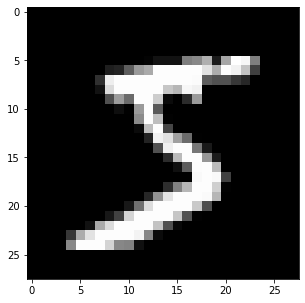

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = 'gray')

## Convolutional Autoencoder

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        #encode layer
        
        self.conv1 = nn.Conv2d(1,16,3, padding = 1)
#         self.conv2 = nn.Conv2d(8,16,3, padding = 1)
        self.conv2 = nn.Conv2d(16,4,3, padding = 1)
        
        #maxpool layer
        
        self.pool = nn.MaxPool2d(2,2)
        
        #decode layer(trans-conv layers)
        
        self.deconv1 = nn.ConvTranspose2d(4,16,2,stride = 2)
        self.deconv2 = nn.ConvTranspose2d(16,1,2,stride = 2)
#         self.deconv3 = nn.ConvTranspose2d(16,1,2,stride = 2)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.pool(x)
        
        x = F.relu(self.deconv1(x))
#         x = F.relu(self.deconv2(x))
        x = F.sigmoid(self.deconv2(x))
        
        return x

model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (deconv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


## Training


In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [26]:
n_epochs = 20

for epoch in range(1,n_epochs+1):
    train_loss = 0.0
    
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss}')

Epoch: 1 	Training Loss: 0.5249415459359685
Epoch: 2 	Training Loss: 0.2199946688146641
Epoch: 3 	Training Loss: 0.20048171063574652
Epoch: 4 	Training Loss: 0.1906050791994979
Epoch: 5 	Training Loss: 0.18298012937419117
Epoch: 6 	Training Loss: 0.1775257113793244
Epoch: 7 	Training Loss: 0.1742036266500751
Epoch: 8 	Training Loss: 0.1720175900372366
Epoch: 9 	Training Loss: 0.1701799921815594
Epoch: 10 	Training Loss: 0.16861514906709393
Epoch: 11 	Training Loss: 0.16695639843431612
Epoch: 12 	Training Loss: 0.1656099408802887
Epoch: 13 	Training Loss: 0.16460474858681362
Epoch: 14 	Training Loss: 0.16384382109778622
Epoch: 15 	Training Loss: 0.16322506324077646
Epoch: 16 	Training Loss: 0.16272683098912238
Epoch: 17 	Training Loss: 0.16228148583943644
Epoch: 18 	Training Loss: 0.1618375398684293
Epoch: 19 	Training Loss: 0.16141284629081687
Epoch: 20 	Training Loss: 0.1609924179657052


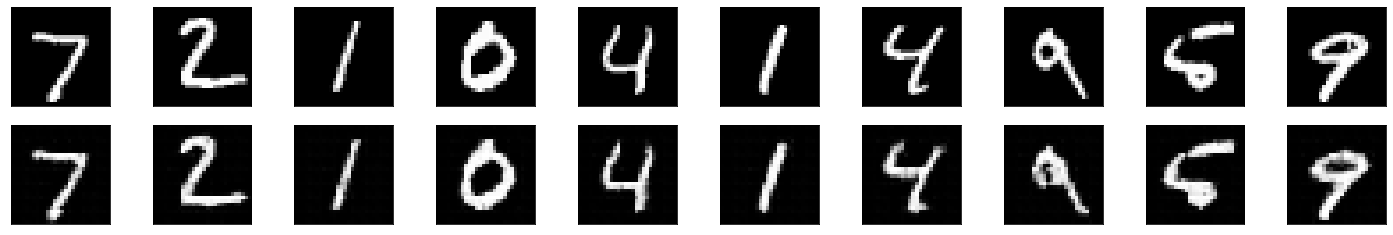

In [27]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
images = images.numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

# plotting the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)